## Headings

In [1]:
import sys, os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.ops import math_ops
from ESN import EchoStateRNNCell
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# memory growth
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# print a progres bar for the cell
from IPython.display import HTML, display
import time
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# random numbers
random_seed = np.frombuffer(os.urandom(4), dtype=np.uint32)[0]
print("seed: ", random_seed)

seed:  2635027120


## The task

We train an ESN on a family of trajectories. At each rollout the ESN is presented with a 1D signal and must reconstruct a 2D trajectory. During training both the ***readout units*** and the ***meta-parameters*** of the ESN are optimized. Test is made on samples from the same family of trajectories that were not presented during learning. 

## Preparing The dataset

We define a simple simulation with a single batch. A timeseries of 'stime' timesteps is run. The input is a inpulse 
given in the first timestep consisting of a gaussian noise given to each unit.

### The dataset generator

In [2]:
class DataGenerator:
    """
        Generates a training and a test dateset.
        
        input: (num_param X stime X input_size) an array of 'num_param' rollouts. Fro each rollout 
            an item is the activation of 'input_size' units. The activation of each unit is based on 
            the radial distance of a fixed position from the index of that unit in the item vector. 
            The fixed position is the parameter from which each rollout is generated.
            and a fading exponential factor based on the position of row item in the rollout (timestep).
        output: (num_param X stime X 2) an array of 'num_param' rollouts. Each item is a  2D point.
            The sequence of points is a sinusoidal trajectory leaving the origin in the direction of a
            fixed angle. The fixed angle is the parameter from which each rollout is generated.
    """
    
    def __init__(self, n_train=10, stime=20, cicles=2, input_size=10): 
        """
        Args:
            n_train: (int) number of training rollouts (test rollouts are 'n_train'-1)
            stime: (int) number of timesteps for each rollout
            cicles: (float) periods of the sinusoidal component of the output
            input_size: (int) number of activations in the input item.
        """
        self.n_train = n_train
        self.n_test = n_train - 1
        self.input_size = input_size
        self.input_radial_std = 0.3
        self.stime = stime
        self.cicles = cicles
        self.t = np.linspace(0, cicles*np.pi, self.stime)
        x = self.t + np.sin(self.t)**2
        y = self.t + np.cos(self.t)**2
        x = x - x[0]
        y = y - y[0]
        self.XY = np.vstack([x.ravel(), y.ravel()])
        
    def rot(self, angle):
        """ Rotation matrix for a given angle
        Args:
            angle: (float) angle of rotation in radiants
            
        Returns:
            rot: (array(2,2)) rotation matrix for 'angle'.
        """
        return np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle), np.cos(angle)]])
    
    def input(self, param):
        """ Gives the input dataset for parameter 'param'
        Args: 
            param: (float) position inthe 1D space of the positions of 
                input activation within a timestep item
        Returns: 
            input_rollout: (stime X input_size) an input rollout 
                (see description in constructor).
        """
        t = np.linspace(-0.2, 1.2,self.input_size) - self.input_radial_std
        t = np.matmul(t.reshape(-1, 1), np.ones([1, self.stime]))
        res =  np.exp(-0.5*(self.input_radial_std**-2)*(t - param)**2)
        res *= np.exp(-np.linspace(0,1,stime)*40).reshape(1, -1)
        return res.T.astype("float32")
    
    def output(self,param):
        """ Gives the output dataset for parameter 'param'
        Args: 
            param: (float) angle of the output sinusoidal trajectory
        Returns: 
            output_rollout: (stime X 2) an output rollout, It is a collection 
                of points defining a sinusoidal trajectory from the origin
                (see description in constructor).
        """
        return np.dot(self.rot(param*0.5*np.pi), self.XY).T.astype("float32")
    
    def train_set(self):
        """ Builds the training set.
        
        Returns:
        
            train_set: (Dict{"inputs": array(num_param, stime, input_size),
                "outputs": array(num_param, stime, 2) ) dictionary with an 
                input dataset and an output dataset. 
        """
        params = np.linspace(0, 1, self.n_train + 1)[:self.n_train]
        
        items = {"inputs": np.array([self.input(param) for param in params]), 
                 "outputs": np.array([self.output(param) for param in params])} 
        return items
    
    def test_set(self):
        """ Builds the test set.
        
        Returns:
        
            test_set: (Dict{"inputs": array(n_train - 1, stime, input_size),
                "outputs": array(n_train -  1, stime, 2) ) dictionary with an 
                input dataset and an output dataset. The test parameters are 
                chosen so that they interpolate the train parameters.
        """
        params = np.linspace(0, 1, self.n_train + 1)[:self.n_train]
        params = params[1:] - np.diff(params)[0]/2
        items = {"inputs": np.array([self.input(param) for param in params]), 
                 "outputs": np.array([self.output(param) for param in params])}
        return items
 

### Global variables

In [3]:
patterns = 10
stime = 30
epochs = 50000
num_units = 400
num_inputs = 10
num_outputs = 2
activation = lambda x:  math_ops.tanh(x)
learning_rate = 0.01

### Generating the train and test sets

In [4]:
# Generating the train and test sets
dg = DataGenerator(stime=stime, n_train=patterns, input_size=num_inputs)
train_set = dg.train_set()
rnn_inputs = train_set["inputs"]
rnn_targets =  train_set["outputs"]
test_set = dg.test_set()
test_inputs = test_set["inputs"]
test_targets = test_set["outputs"]

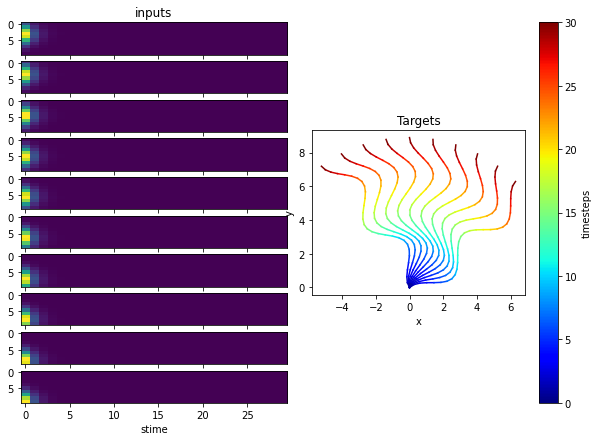

In [5]:
# Plot
plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(patterns, 4)
for p in range(patterns):
    plt.subplot(gs[p,:2])     
    if p == 0:
        plt.title("inputs")
    plt.imshow(rnn_inputs[p].T, aspect="auto")
plt.xlabel("stime")

plt.subplot(gs[:,2:], aspect="equal")
colors = plt.cm.jet(np.linspace(0, 1, stime))
for t in rnn_targets:
    for i in range(1,stime):
        o = plt.plot(*t[i-1:i+1].T, c=colors[i])
#_ = plt.xlim([-dg.cicles*2*np.pi, dg.cicles*2*np.pi])
#_ = plt.ylim([-dg.cicles*2*np.pi, dg.cicles*2*np.pi])
plt.title("Targets")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(0, stime),
    cmap=plt.cm.jet), ax=plt.gca(), label="timesteps")

## Initialize the ESN cell

In [6]:
cell = EchoStateRNNCell(units=num_units, 
                        activation=activation, 
                        decay=0.2, 
                        epsilon=1e-20,
                        alpha=0.5,
                        optimize=True,
                        optimize_vars=["rho", "decay", "alpha", "sw"],
                        seed=random_seed)

recurrent_layer = keras.layers.RNN(cell, input_shape=(stime, num_inputs), 
                                    return_sequences=True, name="nn")
#recurrent_layer = keras.layers.LSTM(num_units, input_shape=(stime, num_inputs), 
#                                   return_sequences=True, name="nn")
output = keras.layers.Dense(2, name="readouts")
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model = keras.models.Sequential()
model.add(recurrent_layer)
model.add(output)

### Activation of the ESN before optimization

(10, 30, 10)


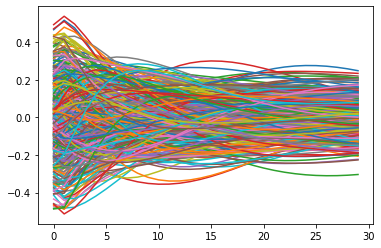

In [7]:
print(rnn_inputs.shape)
inner = model.get_layer("nn")(rnn_inputs[:1]) 
o = plt.plot(inner.numpy().reshape(stime, num_units))

## Training

### Run  a  training on the outputs

In [8]:
out = display(progress(0, epochs), display_id=True)

losses = np.zeros(epochs)  
#alphas = np.zeros(epochs)  

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        
        tape.watch(model.trainable_variables)
                
        # forward  step 
        outputs = model(rnn_inputs)
        # loss
        current_loss = tf.reduce_mean(
            tf.square(outputs - rnn_targets))
    
    # compute and apply gradients
    grads = tape.gradient(current_loss, model.trainable_weights) 
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    #alphas[epoch] = model.get_layer("nn").cell.alpha
    losses[epoch] = current_loss.numpy()
    
    out.update(progress(epoch, epochs))    

### loss curve

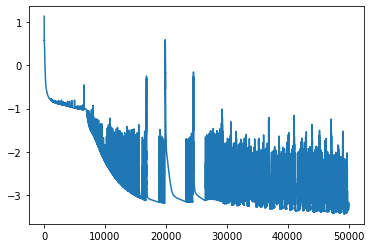

In [9]:
p = plt.plot(np.log10(losses))
plt.show()
#p = plt.plot(alphas)

### Activity of the ESN after optimization

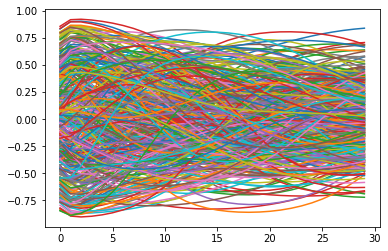

In [10]:
inner = model.get_layer("nn")(np.expand_dims(rnn_inputs[0], 0)) 
o = plt.plot(inner.numpy().reshape(stime, num_units))

### Readout activation after optimization

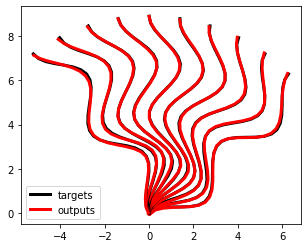

In [11]:
plt.subplot(111, aspect="equal")
for i in range(patterns):
    t = rnn_targets[i,:,:].T
    l1 = plt.plot(t[0], t[1], color="black", lw=3)
    t = np.array(outputs[i,:,:]).T
    l2 = plt.plot(t[0], t[1], color="red", lw=3)  
    plt.legend([l1[0], l2[0]], ["targets", "outputs"])

plt.show()

## Test

### Test trajectories are interpolations of learning trajectories

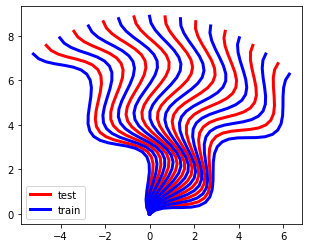

In [12]:
plt.subplot(111, aspect="equal")

for i in range(patterns-1):
    t = test_targets[i,:,:].T
    l1 = plt.plot(t[0], t[1], color="red", lw=3)  

for i in range(patterns):
    t = rnn_targets[i,:,:].T
    l2 = plt.plot(t[0], t[1], color="blue", lw=3)    

plt.legend([l1[0], l2[0]], ["test", "train"])  
plt.show()


### Readout activation in test

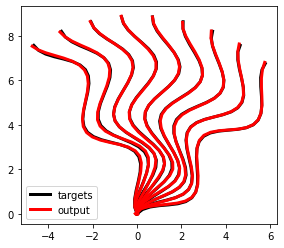

In [13]:
outputs = model(test_inputs).numpy()

plt.subplot(111, aspect="equal")

for i in range(patterns-1):
    t = test_targets[i,:,:].T
    l1 = plt.plot(t[0], t[1], color="black", lw=3)  

for i in range(patterns-1):
    t = outputs[i,:,:].T
    l2 = plt.plot(t[0], t[1], color="red", lw=3)    

plt.legend([l1[0], l2[0]], ["targets", "output"])  
plt.show()
